# Calculate solar energy potential from solar radiation and temperature

Use method in van der Wiel et al (2019): https://www.sciencedirect.com/science/article/pii/S1364032119302862#sec3

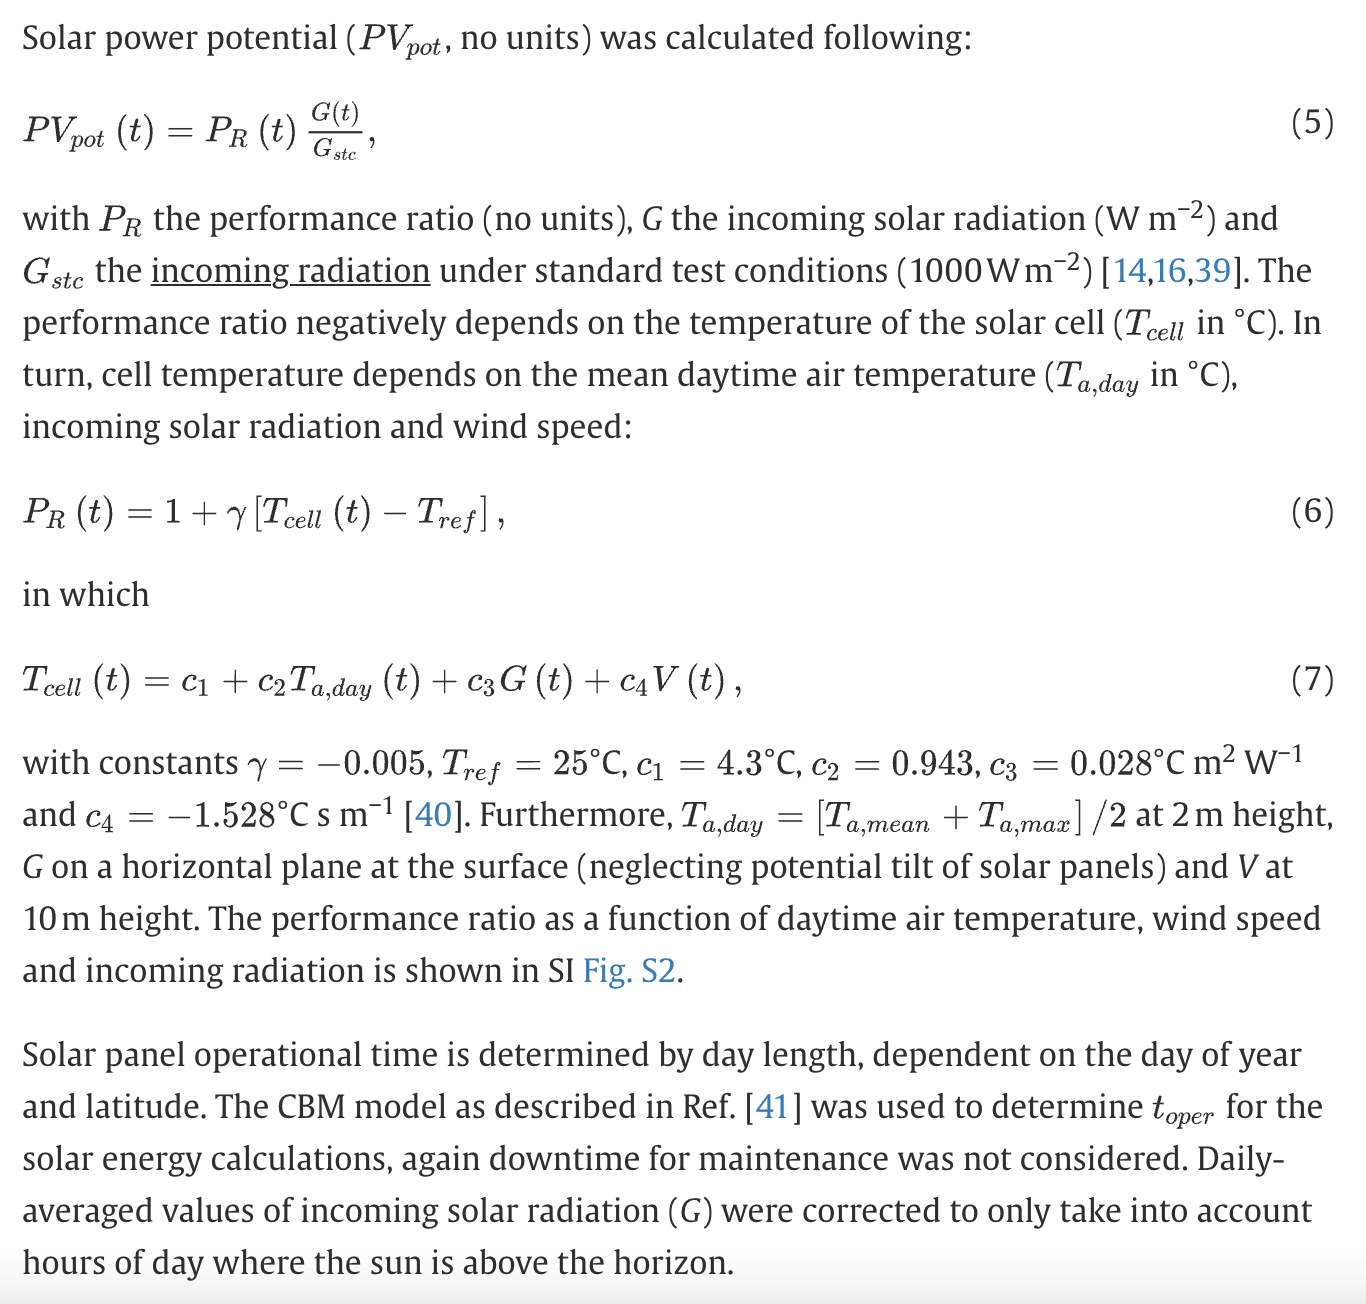

In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [13]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = "00:30:00"
cores = 16
memory = str(4 * cores) + "GB"

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=["-q normal",
                                           "-P w42",
                                           "-l ncpus="+str(cores),
                                           "-l mem="+str(memory),
                                           "-l storage=gdata/w42+gdata/rt52"],
                     local_directory="$TMPDIR",
                     job_directives_skip=["select"])

In [14]:
cluster.scale(jobs=1)
client = Client(cluster)

In [15]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.17:42177,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [2]:
import xarray as xr

import matplotlib.pyplot as plt

In [3]:
%cd /g/data/w42/dr6273/work/energy_climate_modes

import functions as fn

/g/data/w42/dr6273/work/energy_climate_modes


In [4]:
%load_ext autoreload
%autoreload 2

# Load data

In [5]:
years = range(1959, 2023)

In [6]:
aus_region = fn.get_east_Aus_boundary()

In [7]:
data_path = "/g/data/w42/dr6273/work/data/era5/"

In [8]:
def preprocess(ds):
    """
    Preprocess function for open_mfdataset.
    Selects Australian region and renames coords.
    """
    ds = ds.sel(
        longitude=slice(aus_region[0], aus_region[1]),
        latitude=slice(aus_region[2], aus_region[3])
    )
    ds = ds.rename(
        {'longitude': 'lon',
         'latitude': 'lat'}
    )
    return ds

Solar radiation

In [9]:
rad = xr.open_mfdataset(data_path+"/msdwswrf/daily/*.nc", preprocess=preprocess)

In [10]:
rad = rad['msdwswrf']

In [11]:
rad.nbytes / 1024 ** 3

1.0927968621253967

10 m wind speed

In [16]:
w10 = xr.open_mfdataset(data_path+"/10w/daily/*.nc", preprocess=preprocess)

In [17]:
w10 = w10['w10']

Daily mean temperature

In [18]:
t_mean = xr.open_mfdataset(data_path+"/2t/daily/*.nc", preprocess=preprocess)

In [19]:
t_mean = t_mean['t2m']

In [20]:
t_mean = t_mean - 273.15

Daily maximum temperature

In [21]:
t_max = xr.open_mfdataset(data_path+"/2tmax/daily/*.nc", preprocess=preprocess)

In [22]:
t_max = t_max['t2m']

In [23]:
t_max = t_max - 273.15

# Compute solar PV potential

In [24]:
def performance_ratio(T_cell):
    """
    Calculate performance ratio (unitless).
    
    T_cell: cell temperature (deg C)
    """
    T_ref = 25 # reference temperature (deg C)
    gamma = -0.005 # constant
    
    return  1 + gamma * (T_cell - T_ref)

In [25]:
def cell_temperature(T_day, G, V):
    """
    Calculates solar cell temperature.
    
    T_day: daytime temperature (deg C)
    G: incoming solar radiation (W/m^2)
    V: wind speed at 10 m (m/s)
    """
    c1 = 4.3 # deg C
    c2 = 0.943
    c3 = 0.028 # deg C m^2 / W
    c4 = -1.528 # deg C s / m
    
    return c1 + (c2 * T_day) + (c3 * G) + (c4 * V)

In [26]:
def daytime_temperature(T_mean, T_max):
    """
    Calculates mean daytime temperature
    
    T_mean: mean daily temperature (deg C)
    T_max: maximum daily temperature (deg C)
    """
    return (T_mean + T_max) / 2

In [27]:
def PV_potential(G, V, T_mean, T_max):
    """
    Calculate solar power potential (unitless)
    
    G: solar radiation (W/m^2)
    V: wind speed (m/s)
    T_mean: mean daily temperature (deg C)
    T_max: maximum daily temperature (deg C)
    """
    T_day = daytime_temperature(T_mean, T_max)
    T_cell = cell_temperature(T_day, G, V)
    P_R = performance_ratio(T_cell)
    
    G_stc = 1000 # incoming radiation under standard test conditions (1000 W/m^2)
    
    return P_R * G / G_stc

In [32]:
pv = PV_potential(rad, w10, t_mean, t_max)

In [33]:
pv = pv.chunk({"time": 365*10})

In [34]:
pv = pv.to_dataset(name="solar_cf")

In [35]:
write_path = "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/"

pv.to_zarr(
    write_path + "solar_capacity_factor_era5_daily_1959-2022_Aus.zarr",
    mode="w",
    consolidated=True
)

In [36]:
pv = xr.open_zarr(
    write_path + "solar_capacity_factor_era5_daily_1959-2022_Aus.zarr",
    consolidated=True
)

### 2014-2016 time series for near Sydney

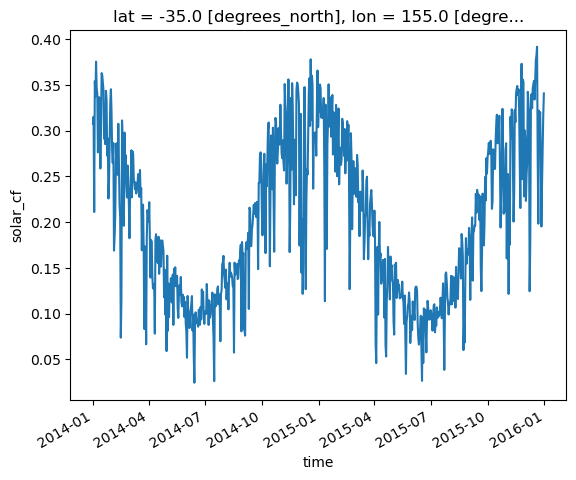

In [37]:
pv['solar_cf'].sel(lat=-35, lon=155, time=slice("2014", "2015")).plot()

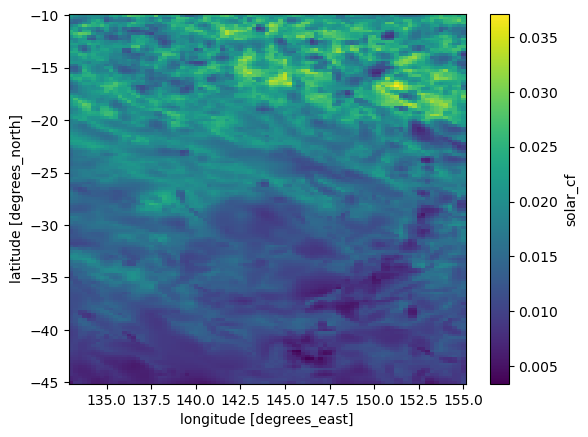

In [38]:
pv['solar_cf'].min('time').plot()

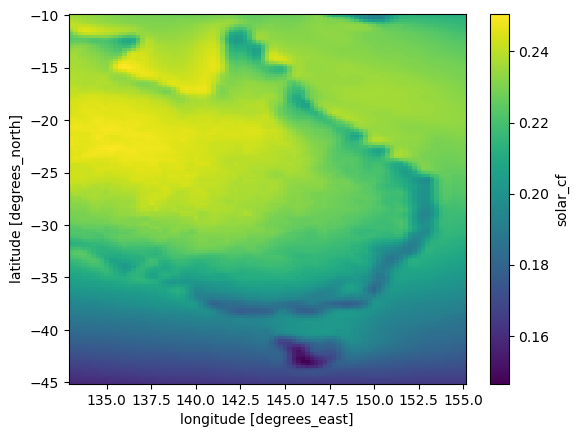

In [39]:
pv['solar_cf'].mean('time').plot()

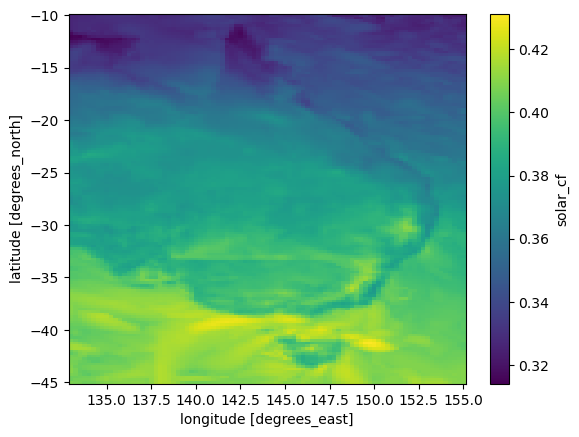

In [40]:
pv['solar_cf'].max('time').plot()

### Performance ratio

As a function of daytime temperature, wind speed and radiation.

Trying to replicate fig S2 from: https://ars.els-cdn.com/content/image/1-s2.0-S1364032119302862-mmc1.pdf

In [85]:
import numpy as np

In [88]:
dummy_t = np.linspace(-10, 40, 100)
dummy_w = np.linspace(0, 25, 100)
dummy_G = np.repeat(400, 100)

In [94]:
P_R = np.empty((100, 100))

In [95]:
for i,w in enumerate(dummy_w):
    for j, t in enumerate(dummy_t):
        T_cell = cell_temperature(t, 400, w)
        P_R[i, j] = performance_ratio(T_cell)

In [103]:
P_R = xr.DataArray(
    P_R.transpose(),
    dims = ['T', 'W'],
    coords = {'T': dummy_t, 'W': dummy_w}
)

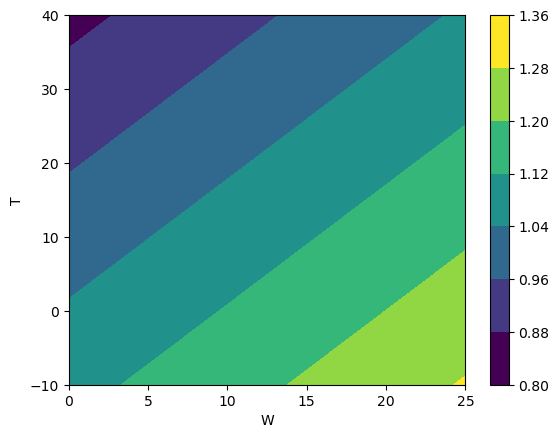

In [105]:
P_R.plot.contourf()

# Close cluster

In [106]:
client.close()
cluster.close()